It is a pain to have to keep dumping compute and garbage text files just to regenerate J each time.
The point of this notebook is to carefully review the process of J calculation,
so that we can perform it just once and save to the result to a shared numpy zip file.

In [1]:
%matplotlib notebook
import flux

Missing flux value for: GLEAM J202818-254302 at frequency: 204 MHz.
Missing flux value for: GLEAM J202818-254302 at frequency: 212 MHz.
Missing flux value for: GLEAM J202818-254302 at frequency: 220 MHz.
Missing flux value for: GLEAM J202818-254302 at frequency: 227 MHz.
Missing spectral index for: GLEAM J202818-254302


//anaconda3/envs/hera/lib/python3.7/site-packages/spin1_beam_model/jones_matrix_field.py:18: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.pos1_Elm_samples = h5f["pos1_Elm"].value
//anaconda3/envs/hera/lib/python3.7/site-packages/spin1_beam_model/jones_matrix_field.py:19: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.neg1_Elm_samples = h5f["neg1_Elm"].value
//anaconda3/envs/hera/lib/python3.7/site-packages/spin1_beam_model/jones_matrix_field.py:20: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.freq_nodes = h5f["frequencies"].value
//anaconda3/envs/hera/lib/python3.7/site-packages/spin1_beam_model/jones_matrix_field.py:21: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.L_model = h5f["spatial_bandlimit"].value
//anaconda3/envs/hera/lib/python3.7/site-packages/spin1_beam_model/jones_matrix_field.py:22: H5pyDeprec

delta_nu_in is 1000000.0


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp

In [3]:
list_az = []
list_alt = []
for source in flux.catalog.obj_catalog:
    ra = np.radians(source.ra_angle)
    dec = np.radians(source.dec_angle)
    az, alt = flux.rot.eq_to_topo(
        ra, dec,
        np.radians(flux.rot.hera_lat),
        np.pi / 3, radians=True
    )
    list_az.append(az)
    list_alt.append(alt)

In [4]:
# reformat into arrays so that the spline function can handle the single angles
list_az = np.array(list_az)
list_alt = np.array(list_alt)
print(list_az)
print(list_alt)

[ 2.56076381 -2.107263   -1.51697037 ... -2.81943358 -1.43876057
 -2.72847459]
[-0.28249343  0.33905297  0.98724966 ... -0.50445313  1.0037142
 -0.32730335]


In [5]:
#nside = 16, 32, 64, 128...
nside = 128

# healpix does the interpolation for you?
theta, phi = hp.pix2ang(nside, np.arange(12 * nside * nside))
az = phi
alt = np.pi / 2 - theta
J = flux.stokes.spline_beam_func(150e6, alt, az)
print(theta, phi)

[0.00637889 0.00637889 0.00637889 ... 3.13521376 3.13521376 3.13521376] [0.78539816 2.35619449 3.92699082 ... 2.35619449 3.92699082 5.49778714]


In [6]:
J = flux.stokes.spline_beam_func(150e6, list_alt, list_az)
J.shape

(3872, 2, 2)

In [7]:
empty_blocks = 0
for block in J:
    """
    Make sure that at least one LST works in the day.
    """
    if block[0][0] == 0 and \
        block[1][0] == 0 and \
        block[0][1] == 0 and \
        block[1][1] == 0:
        empty_blocks += 1
empty_blocks

1484

In [8]:
""" This is a major problem, is it not? """
percent_empty = 100 * empty_blocks / len(J)
percent_empty

38.32644628099174

In [9]:
def rad_interp(J_section, ra, dec, lst):
    """
    Abbreviation and conversion function. We get the interpolation value
    assuming @az and @alt are in degrees.
    """
    az, alt = flux.rot.eq_to_topo(ra, dec, lat=np.radians(flux.rot.hera_lat), lst=lst, radians=True)
    colatitude = np.radians(90 - alt)
    longitude = np.radians(az)
    return hp.get_interp_val(J_section, colatitude, longitude)

In [16]:
# Hard-coding a right-ascension,
# this should be a maximum response...

# the cold patch represents degrees 0 through 120

ra_max = np.radians(59.984791666666666)
dec_max = np.radians(-23.4345)

J_max = flux.stokes.J_matrix(np.pi/3, dec, lst=np.pi / 3)
print("xx:", J_max[0][0][1])
print("yy:", J_max[0][1][0])
J_max.shape

xx: 0j
yy: (-0+0j)


(1, 2, 2)

<IPython.core.display.Javascript object>


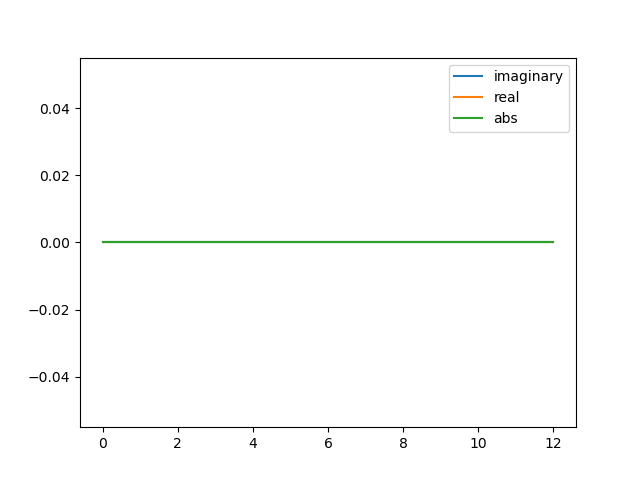

In [13]:
dec_decf = np.radians(-30.72)

ra_decf = 0

first_term = []

while ra_decf <= 120:
    J_decf = flux.stokes.J_matrix(
        np.radians(ra_decf), dec_decf, lst=np.pi / 3
    )
    #print("\nDeclination (degrees):", np.around(np.degrees(dec_decf), 2),
    #    "\nRight acension (degrees):", np.around(ra_decf, 2),
    #    "\nResultant J matrix:\n", J_decf, "\n")
    first_term.append(J_decf[0][0][1])
    ra_decf += 10
im = np.imag(np.array(first_term))
re = np.real(np.array(first_term))
ab = np.abs(np.array(first_term))
plt.plot(im, label="imaginary")
plt.plot(re, label="real")
plt.plot(ab, label="abs")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


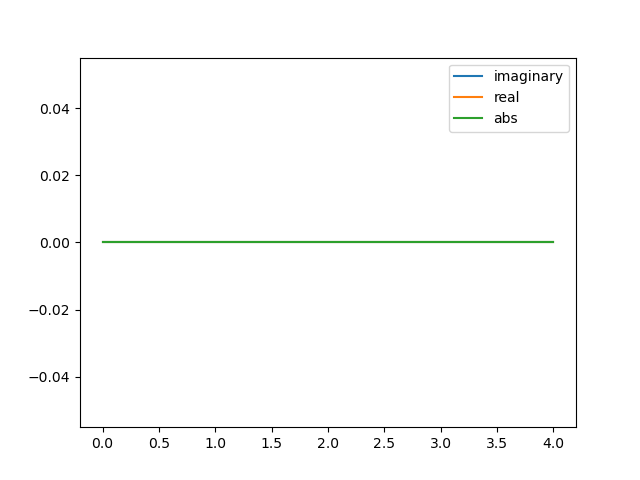

In [14]:
dec_raf = -40.72

ra_raf = np.radians(59.984791666666666)

first_term = []

while dec_raf <= -20.72:
    J_raf = flux.stokes.J_matrix(
        ra_raf, np.radians(dec_raf), lst=np.pi / 3
    )
    #print("\nDeclination (degrees):", np.around(dec_decf, 2),
    #      "\nRight acension (degrees):", np.around(np.degrees(ra_decf), 2),
    #      "\nResultant J matrix:\n", J_raf, "\n")
    first_term.append(J_raf[0][0][1])
    dec_raf += 5
im = np.imag(np.array(first_term))
re = np.real(np.array(first_term))
ab = np.abs(np.array(first_term))
plt.plot(im, label="imaginary")
plt.plot(re, label="real")
plt.plot(ab, label="abs")
plt.legend()
plt.show()